# Polynomial model fit

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as P
import pandas as pd
import glob
import os
import math
import importlib
%matplotlib inline

import amaizeing_utils as maize

## Wrangle the input file

Load the data file

In [2]:
src = '../model/'
data = pd.read_excel(src + '2019GXEleaf_angle.xlsx')
data.head()

,Unnamed: 0,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,LPlant.L1.End.Angle,...,RPlant.L1.End.Angle,RPlant.L1.End.Length,RPlant.L1.Mid.Angle,RPlant.L1.Mid.Length,RPlant.L1.Stem.Angle,RPlant.L2.End.Angle,RPlant.L2.End.Length,RPlant.L2.Mid.Angle,RPlant.L2.Mid.Length,RPlant.L2.Stem.Angle
0,1,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,60,...,65,58.0,55.0,66.0,26.0,90,46.0,50.0,47.0,31.0
1,2,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,45,...,53,59.0,33.0,63.0,23.0,75,43.0,43.0,48.0,15.0
2,3,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,65,...,61,62.0,48.0,70.0,25.0,43,46.0,33.0,65.0,27.0
3,4,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,70,...,75,52.0,54.0,58.0,23.0,85,69.0,48.0,49.0,33.0
4,5,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN,90,...,64,48.0,45.0,60.0,20.0,90,45.0,52.0,39.0,29.0


Separate the metadata from the measures themselves

In [3]:
meta = data.iloc[:, 1:9]
meta.head()

,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared
0,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN
4,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN


This file contains actually measures from four different plants. Identify the column number where a different plant starts

In [6]:
endAngle = []
for i,name in enumerate(data.columns):
    if "End.Angle" in name:
        print('{}:\t{}'.format(i,name))
        endAngle.append(i)

9:	LPlant.L1.End.Angle
14:	LPlant.L2.End.Angle
20:	RPlant.L1.End.Angle
25:	RPlant.L2.End.Angle


Get the five different measures for a plant
- Three angles with respect to the stem
- Two distances from the base

In [39]:
bladeset = 2
numbers = data.iloc[:, endAngle[bladeset]:(endAngle[bladeset]+5)].dropna(axis='index', how='any')
mask = numbers[data.columns[endAngle[bladeset]]].isin(['90+'])
numbers.loc[mask, data.columns[endAngle[bladeset]]] = 90
mask = numbers[data.columns[endAngle[bladeset]]].isin(['90++'])
numbers.loc[mask, data.columns[endAngle[bladeset]]] = 90
numbers = numbers[numbers[data.columns[endAngle[bladeset]]] != 90]

print(numbers.shape)
numbers.head()

(379, 5)


,RPlant.L1.End.Angle,RPlant.L1.End.Length,RPlant.L1.Mid.Angle,RPlant.L1.Mid.Length,RPlant.L1.Stem.Angle
0,65,58.0,55.0,66.0,26.0
1,53,59.0,33.0,63.0,23.0
2,61,62.0,48.0,70.0,25.0
3,75,52.0,54.0,58.0,23.0
4,64,48.0,45.0,60.0,20.0


Concatenate the metadata with the information specific of this side of the plot. 

In [40]:
plotname = '.'.join(numbers.columns[0].split('.')[:2])
PlotData = pd.concat([meta, numbers], axis=1, join='inner')
PlotData.head()

,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,RPlant.L1.End.Angle,RPlant.L1.End.Length,RPlant.L1.Mid.Angle,RPlant.L1.Mid.Length,RPlant.L1.Stem.Angle
0,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,65,58.0,55.0,66.0,26.0
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,53,59.0,33.0,63.0,23.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,61,62.0,48.0,70.0,25.0
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,75,52.0,54.0,58.0,23.0
4,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN,64,48.0,45.0,60.0,20.0


Separate the columns that measure angles from the columns that measure distances.

In [33]:
lengthCols = []
angleCols = []
for i,name in enumerate(numbers.columns):
    if ".Length" in name:
        lengthCols.append(i)
    if ".Angle" in name:
        angleCols.append(i)
print(lengthCols)
print(angleCols)

[1, 3]
[0, 2, 4]


In [41]:
degs = np.flip(np.array(numbers.drop(columns=numbers.columns[lengthCols]), 
                        dtype=np.float), axis=1)
lengths = np.flip(np.array(numbers.drop(columns=numbers.columns[angleCols]), 
                        dtype=np.float), axis=1)

## Fit two simple polynomials, one going upwards, other downwards

### Shower thoughts

$$f_{\text{base to top}}(x) = A_1(x-B_1)^{N_1} + C_1$$
$$g_{\text{top to tip}}(x) = A_2(x-B_2)^{N_2} + C_1$$

- The problem is to find $A,B,C,N$ adequate.
- ~~Main issue is that $N$ must be a natural number.~~
- ~~This is usually not the case when solving the equation.~~
- ~~Use $\lceil N\rceil$ (ceil) or $\lfloor N\rfloor$ (floor) instead.~~ 


Inspired by the following

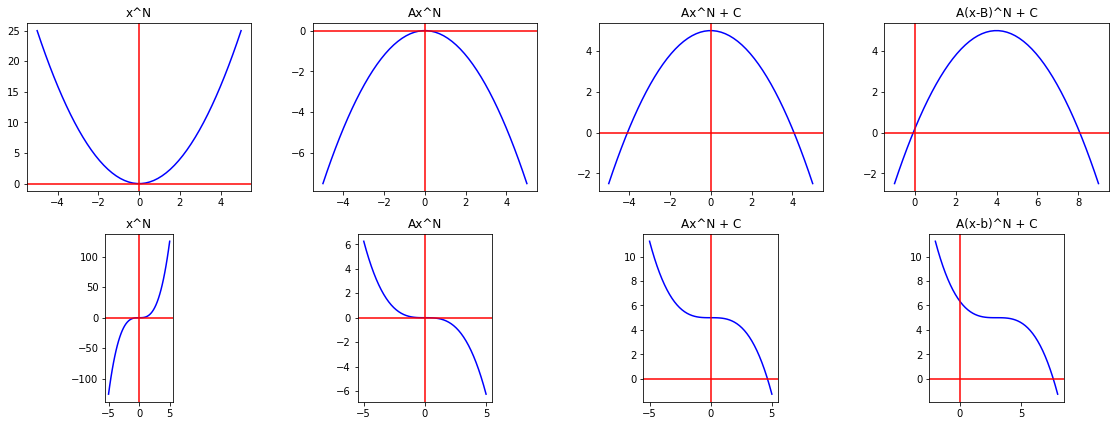

In [10]:
maize.shower_thought()

## Main problem: we don't know the angle formed by the tip of the leaf dangling.

- We can solve easily the first half: from base to top.
    - We know the angle formed by the base of the leaf with the stem
    
- We do not have an extra angle measure when it comes to the tip
    - We assume that the leaf dangles with the same angle as the one between the base and the stem.
    - We can correct that angle if the the resulting polynomial model is too steep (low $N$) or too flat (high $N$)

In [12]:
importlib.reload(maize)
idx = 305

deg = np.sort(degs[idx])
length = lengths[idx]
deg = 90 - deg
if deg[0] > 89:
    deg[0] = 89
print(deg)
print(length)

wblade, wparams = maize.poly_weight_blade_fit(deg, length, 100, dangle_correction=True)
ublade, uparams = maize.poly_weight_blade_fit(deg, length, 100, dangle_correction=False)

blade, params, _ = maize.poly_blade_fit(deg, length, 100)
dblade, dparams, _ = maize.poly_blade_fit(deg, length, 100, dangle_correction=False)

[61. 40. 31.]
[68. 61.]


	Model 0
Up::::	A = -1.61e-02	N = 2.15
Down::	B = -1.23e+01	M = 0.03
	Model 1
Up::::	A = -1.61e-02	N = 2.15
Down::	B = -1.23e+01	M = 0.30
	Model 2
Up::::	A = 8.90e-03	N = 2.15
Down::	B = 0.00e+00	M = 0.00
	Model 3
Up::::	A = 8.90e-03	N = 2.15
Down::	B = 0.00e+00	M = 0.00
--------
a = 52.09	c = 43.71
b = 52.29	d = 31.42
-------


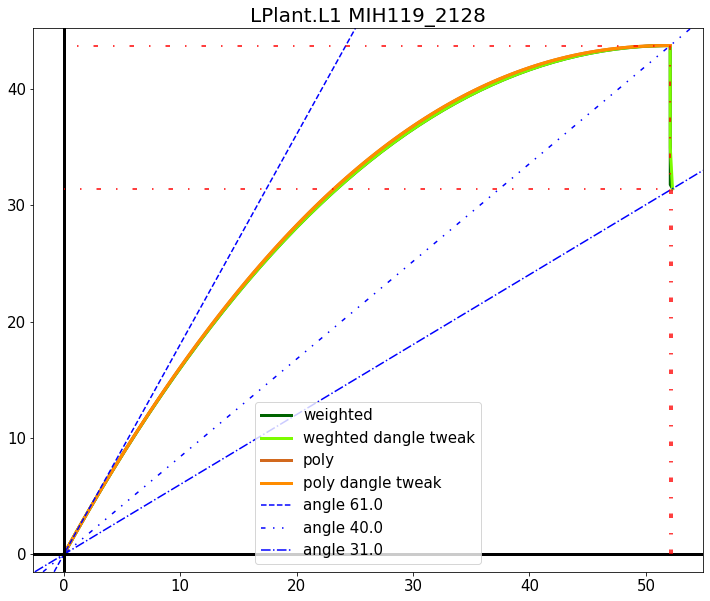

In [13]:
title = '.'.join(numbers.columns[0].split('.')[:2]) + ' ' + PlotData.iloc[idx,0]
maize.plot_poly_blade([ublade,wblade,dblade,blade], deg, 
                      [uparams,wparams,dparams,params], title=title, 
                      labels=['weighted','weghted dangle tweak','poly', 'poly dangle tweak'], 
                      verbose=True)

## 

## Compute the polynomial coefficients for the rest of leaves

In [42]:
resol = 100
Params= np.empty((len(degs), 8))
Blade = [None for i in range(len(degs))]
NormBlade = []
Extra = np.empty((len(degs), 2))

for idx in range(len(degs)):
    deg = np.sort(degs[idx])
    length = lengths[idx]
    deg = 90 - deg
    if deg[0] > 89:
        deg[0] = 89
    
    blade, params, down_curled = maize.poly_blade_fit(deg, length, resol)
    length_blade = np.sum(np.sqrt(np.sum(np.diff(blade, axis=0)**2, axis=1)))
    
    if down_curled:
        length_blade *= 1.75

    norm_blade = blade/length_blade
    
    Params[idx,:] = params
    Extra[idx, :] = length_blade, down_curled
    Blade[idx] = blade
    
    if not down_curled:
        NormBlade.append(norm_blade)

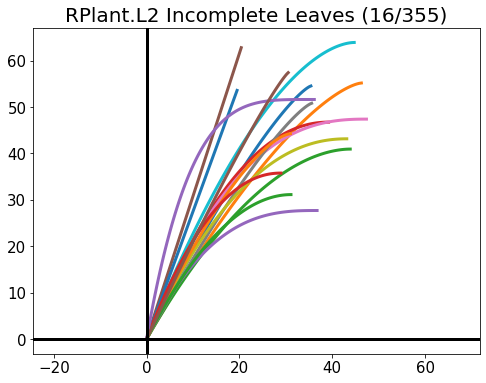

In [36]:
dst = '../model/'
plotname = '.'.join(numbers.columns[0].split('.')[:2])
curled = np.nonzero(Extra[:,1])[0]

plt.figure(figsize=(8,6))

for i in curled:
#for i in range(50,63):
    plt.plot(Blade[i][:,0], Blade[i][:,1], lw=3, label=i)

plt.axvline(x=0, c='k', lw=3)
plt.axhline(y=0, c='k', lw=3)
#plt.legend()
plt.title(plotname + ' Incomplete Leaves ({}/{})'.format(len(curled),len(Blade)),
          fontsize=20)
plt.tick_params(labelsize=15)
plt.axis('equal');

filename = dst + 'poly_model_' + plotname + '_incomplete_leaves.png'
plt.savefig(filename, dpi=150, format='png', bbox_inches='tight',
                    facecolor='white', transparent=False)

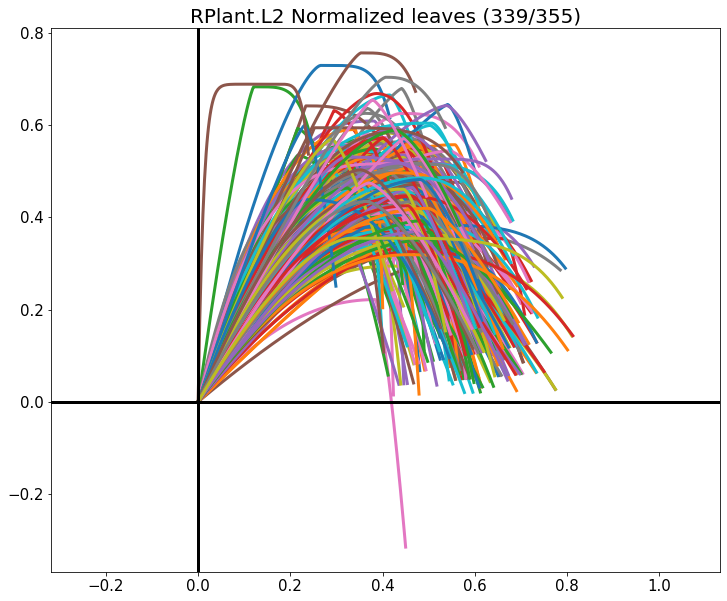

In [37]:
plt.figure(figsize=(12,10))

for i in range(len(NormBlade)):
#for i in range(50,63):
    plt.plot(NormBlade[i][:,0], NormBlade[i][:,1], lw=3)

plt.axvline(x=0, c='k', lw=3)
plt.axhline(y=0, c='k', lw=3)
plt.title(plotname + ' Normalized leaves ({}/{})'.format(len(NormBlade),len(Blade)), fontsize=20)
plt.tick_params(labelsize=15)
plt.axis('equal');

filename = dst + 'poly_model_' + plotname + '_normalized.png'
plt.savefig(filename, dpi=150, format='png', bbox_inches='tight',
                    facecolor='white', transparent=False)

## Save the coefficients in a CSV

In [43]:
param_df = pd.DataFrame(np.column_stack((Params,Extra)), 
                        index=PlotData.index, 
                        columns=['A1','N1','A2','N2','a','b','c','d','length','curled'])
df = pd.concat([PlotData, param_df], axis=1, join='inner')
df.to_csv(dst + plotname + '_poly_model.csv', index=True)
df

,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,RPlant.L1.End.Angle,RPlant.L1.End.Length,...,A1,N1,A2,N2,a,b,c,d,length,curled
0,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,65,58.0,...,0.000319,2.928137,0.000000e+00,0.000000,54.064035,52.565852,37.856045,24.511859,124.345592,1.0
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,53,59.0,...,0.236502,1.529908,-2.044452e-01,1.741109,34.312259,47.119495,52.836246,35.507086,86.408097,0.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,61,62.0,...,0.003830,2.381716,-5.696030e+00,1.365426,52.020138,54.226422,46.839142,30.058196,91.392177,0.0
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,75,52.0,...,0.000130,3.242553,-3.590503e+00,1.462669,46.922986,50.228143,34.091545,13.458590,84.187749,0.0
4,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN,64,48.0,...,0.001431,2.747477,0.000000e+00,0.000000,42.426407,43.142114,42.426407,21.041815,113.756627,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,MIH119_2245,12,19,2,PHW65_MoG_0622/PHT69,PHW65_MoG_0622/PHT69,WIPV17/30593,1.0,81,58.0,...,0.031358,1.923637,-4.713020e-01,1.340257,37.900386,57.285924,34.125661,9.073199,85.030604,0.0
495,MIH119_2246,11,19,2,PHW65_MoG_0633/PHT69,PHW65_MoG_0633/PHT69,WIPV17/31195,1.0,86,50.0,...,0.304991,1.325418,-6.042184e-01,1.428064,34.528310,49.878203,33.343602,3.487824,82.392860,0.0
496,MIH119_2247,10,19,2,PHW65_MoG_0651/PHT69,PHW65_MoG_0651/PHT69,WIPV17/31196,1.0,78,63.0,...,0.121129,1.524971,-6.313812e-02,1.755401,37.303006,61.623299,30.207379,13.098437,79.373498,0.0
497,MIH119_2248,9,19,2,PHW65_MoG_0660/PHT69,PHW65_MoG_0660/PHT69,WIPV17/31197,1.0,66,72.0,...,0.042711,1.884649,-1.602366e-02,2.314168,43.066770,65.775273,51.324978,29.285038,103.306490,0.0


## Make individual blade model plots

In [37]:
dst = '../model/rpl1/'

importlib.reload(maize)
for idx in range(len(degs)):
    title = '.'.join(numbers.columns[0].split('.')[:2]) + ' ' + PlotData.iloc[idx,0]
    deg = np.sort(degs[idx])
    deg = 90 - deg
    if deg[0] > 89:
        deg[0] = 89
    
    maize.plot_poly_blade([Blade[idx]], deg, [Params[idx]], 
                          title=title, labels=['Polymodel'], dpi=40, dst=dst,
                         writefig=True)